<h1><b>Image Captioning from Flickr30k

<h2><b>Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import re
from tqdm.notebook import tqdm
from pprint import pprint
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from keras.models import Model
from keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<h2><b>Image Feature Extraction

Using <b>VGG16</b> model to extract feature from image.

In [2]:
model_img = VGG16()
model_img = Model(inputs = model_img.input, outputs = model_img.layers[-2].output)
model_img.summary()

553467096/553467096 [==============================] - 22s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
model_img.save('/kaggle/working/Flickr30k_VGG16.h5')

In [3]:
BASE_DIR = '/kaggle/input/flickr-image-dataset/flickr30k_images'
len(os.listdir(BASE_DIR + '/flickr30k_images'))

31785

In [4]:
os.listdir(BASE_DIR + '/flickr30k_images')[:5]

['2715746315.jpg',
 '3463034205.jpg',
 '268704620.jpg',
 '2673564214.jpg',
 '7535037918.jpg']

In [5]:
os.listdir(BASE_DIR + '/flickr30k_images')[9746:9748]

['3350185126.jpg', 'flickr30k_images']

In [ ]:
features = {}
for img_id in tqdm(os.listdir(BASE_DIR + '/flickr30k_images')[:15000]):
    try:
        image = load_img(BASE_DIR + '/flickr30k_images/' + img_id, target_size = (224, 224))
        img_id = img_id.split('.')[0]
        img_arr = img_to_array(image)
        img_arr = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
        img_arr = preprocess_input(img_arr)
        feature = model_img.predict(img_arr, verbose = 0)
        features[img_id]= feature
    except:
        pass
pickle.dump(features, open('Flickr30k_features_1.pkl', 'wb'))

In [ ]:
features = {}
for img_id in tqdm(os.listdir(BASE_DIR + '/flickr30k_images')[15000:]):
    try:
        image = load_img(BASE_DIR + '/flickr30k_images/' + img_id, target_size = (224, 224))
        img_id = img_id.split('.')[0]
        img_arr = img_to_array(image)
        img_arr = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
        img_arr = preprocess_input(img_arr)
        feature = model_img.predict(img_arr, verbose = 0)
        features[img_id]= feature
    except:
        pass
pickle.dump(features, open('Flickr30k_features_2.pkl', 'wb'))

In [6]:
with open('/kaggle/input/flickr30k-features-1/Flickr30k_features_1.pkl', 'rb') as f:
    features_1 = pickle.load(f)
with open('/kaggle/input/flickr30k-features-1/Flickr30k_features_2.pkl', 'rb') as f:
    features_2 = pickle.load(f)
features = {}
features.update(features_1)
features.update(features_2)
print(len(features))

31783


<h2><b>Reading Dataset

In [7]:
caption_doc = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv', sep = '|', usecols = [0, 2])
print('shape:\t', caption_doc.shape)
caption_doc.sample(5)

shape:	 (158915, 2)


,image_name,comment
241,1012328893.jpg,A group of people enjoying a beautiful day in...
135408,5485593000.jpg,A man in a white shirt and jeans sweeps the s...
137574,5721530415.jpg,A team of chefs work to prepare a meal .
112031,4703377742.jpg,Groups of people are having conversations wit...
25902,2351870496.jpg,Two men and a woman play with a dog in the wa...


<h2><b>Data Preprocessing

In [8]:
caption_doc.columns

Index(['image_name', ' comment'], dtype='object')

In [9]:
caption_doc.isna().sum()

image_name    0
 comment      1
dtype: int64

In [10]:
list(caption_doc[caption_doc['image_name']=='2199200615.jpg'].iloc[:, 1])

[' A dog running on green grass with its mouth open and tongue hanging out .',
 ' a white dog is running with its mouth open across the grass .',
 ' A white , black , and brown dog runs in a field .',
 ' A dog runs across the grassy field .',
 nan]

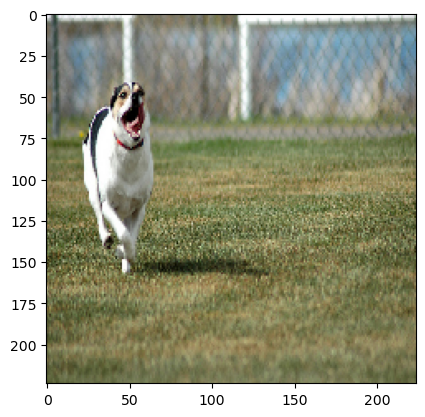

In [11]:
image = load_img(BASE_DIR + '/flickr30k_images/' + '2199200615.jpg', target_size = (224, 224))
plt.imshow(image)

In [12]:
caption_doc.fillna('A white and black dog is running across grassy field with its mouth open', inplace = True)

In [13]:
grp_captions = caption_doc.groupby('image_name')

In [14]:
grp_captions.get_group('2199200615.jpg')

,image_name,comment
19995,2199200615.jpg,A dog running on green grass with its mouth o...
19996,2199200615.jpg,a white dog is running with its mouth open ac...
19997,2199200615.jpg,"A white , black , and brown dog runs in a fie..."
19998,2199200615.jpg,A dog runs across the grassy field .
19999,2199200615.jpg,A white and black dog is running across grassy...


In [15]:
mapping = grp_captions[' comment'].apply(list).to_dict()
len(mapping)

31783

In [16]:
list(mapping.items())[:3]

[('1000092795.jpg',
  [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
   ' Two young , White males are outside near many bushes .',
   ' Two men in green shirts are standing in a yard .',
   ' A man in a blue shirt standing in a garden .',
   ' Two friends enjoy time spent together .']),
 ('10002456.jpg',
  [' Several men in hard hats are operating a giant pulley system .',
   ' Workers look down from up above on a piece of equipment .',
   ' Two men working on a machine wearing hard hats .',
   ' Four men on top of a tall structure .',
   ' Three men on a large rig .']),
 ('1000268201.jpg',
  [' A child in a pink dress is climbing up a set of stairs in an entry way .',
   ' A little girl in a pink dress going into a wooden cabin .',
   ' A little girl climbing the stairs to her playhouse .',
   ' A little girl climbing into a wooden playhouse ',
   ' A girl going into a wooden building .'])]

<h2><b>Caption Preprocessing

<h4><b>Steps</b></h4>
<ul>
<li> Convert sentences into lowercase
<li> Remove special characters and numbers present in the text
<li> Remove extra spaces
<li> Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence
<ul>

In [17]:
def caption_preprocessing(mapping):
    for img_id, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub('[^A-Za-z ]', '', caption)
            caption = re.sub(' +', ' ', caption)
            caption = 'startseq' + caption + 'endseq'
            captions[i] = caption

In [18]:
mapping['10002456.jpg']

[' Several men in hard hats are operating a giant pulley system .',
 ' Workers look down from up above on a piece of equipment .',
 ' Two men working on a machine wearing hard hats .',
 ' Four men on top of a tall structure .',
 ' Three men on a large rig .']

In [19]:
caption_preprocessing(mapping)

In [20]:
mapping['10002456.jpg']

['startseq several men in hard hats are operating a giant pulley system endseq',
 'startseq workers look down from up above on a piece of equipment endseq',
 'startseq two men working on a machine wearing hard hats endseq',
 'startseq four men on top of a tall structure endseq',
 'startseq three men on a large rig endseq']

In [21]:
all_caption = []
for img_name, captions in mapping.items():
    for caption in captions:
        all_caption.append(caption)
len(all_caption)

158915

In [22]:
all_caption[108:112]

['startseq a crowd is portrayed near a metro station endseq',
 'startseq crowd standing outside a metro area endseq',
 'startseq a man with a goatee in a black shirt and white latex gloves is using a tattoo gun to place a tattoo on someone s back endseq',
 'startseq a man is putting a tattoo on a another s man upper back endseq']

<h3>Tokenization

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) + 1

In [47]:
pickle.dump(tokenizer, open('Flickr30k_tokenizer.pkl', 'wb'))

In [24]:
vocab_size

21524

In [25]:
max_length = max(len(caption.split()) for caption in all_caption)
max_length

80

<h2><b>Train Test Split

In [26]:
image_name = list(mapping.keys())
split = int(len(image_name)*0.9)
train = image_name[:split]
test = image_name[split:]

<h3>Data Generator for Batch Training

In [27]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(caption.split())):
                               in_seq, out_seq = seq[:i], seq[i]
                               in_seq = pad_sequences([in_seq], max_length)[0]
                               out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                               ind_x = key.split('.')[0]
                               X1.append(features[ind_x][0])
                               X2.append(in_seq)
                               y.append(out_seq)
                if n==batch_size:
                               X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                               yield [X1, X2], y
                               X1, X2, y = [], [], []
                               n = 0

<h2><b>Model Building

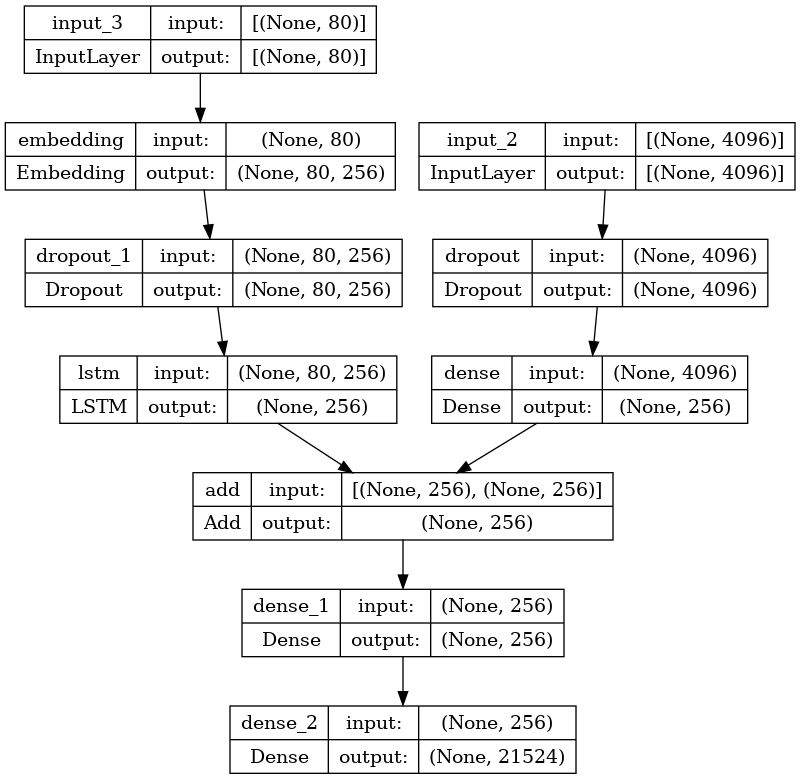

In [28]:
# encoder
# image feature
inputs1 = Input(shape = (4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq feature layer
inputs2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes = True)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 256)      5510144     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [30]:
os.mkdir('/kaggle/working/models')

<h3><b>Training

In [31]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

filepath = '/kaggle/working/models/model-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

In [33]:
for i in range(10):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 1
893/893 [==============================] - ETA: 0s - loss: 4.2336
Epoch 1: saving model to /kaggle/working/models/model-01.h5
893/893 [==============================] - 641s 710ms/step - loss: 4.2336
Epoch:	 2
893/893 [==============================] - ETA: 0s - loss: 3.4065
Epoch 1: saving model to /kaggle/working/models/model-01.h5
893/893 [==============================] - 603s 674ms/step - loss: 3.4065
Epoch:	 3
893/893 [==============================] - ETA: 0s - loss: 3.1673
Epoch 1: saving model to /kaggle/working/models/model-01.h5
893/893 [==============================] - 604s 676ms/step - loss: 3.1673
Epoch:	 4
893/893 [==============================] - ETA: 0s - loss: 3.0122
Epoch 1: saving model to /kaggle/working/models/model-01.h5
893/893 [==============================] - 601s 672ms/step - loss: 3.0122
Epoch:	 5
893/893 [==============================] - ETA: 0s - loss: 2.8972
Epoch 1: saving model to /kaggle/working/models/model-01.h5
893/893 [===============

In [34]:
model.save('/kaggle/working/models/final_model_0010.h5')

In [33]:
model = load_model('/kaggle/input/final-models/final_model_0010.h5')

In [34]:
filepath = '/kaggle/working/models/model_1020-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

for i in range(10, 20):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 11
893/893 [==============================] - ETA: 0s - loss: 2.5729
Epoch 1: saving model to /kaggle/working/models/model_1020-01.h5
893/893 [==============================] - 737s 818ms/step - loss: 2.5729
Epoch:	 12
893/893 [==============================] - ETA: 0s - loss: 2.5462
Epoch 1: saving model to /kaggle/working/models/model_1020-01.h5
893/893 [==============================] - 636s 712ms/step - loss: 2.5462
Epoch:	 13
893/893 [==============================] - ETA: 0s - loss: 2.5224
Epoch 1: saving model to /kaggle/working/models/model_1020-01.h5
893/893 [==============================] - 627s 702ms/step - loss: 2.5224
Epoch:	 14
893/893 [==============================] - ETA: 0s - loss: 2.5026
Epoch 1: saving model to /kaggle/working/models/model_1020-01.h5
893/893 [==============================] - 629s 704ms/step - loss: 2.5026
Epoch:	 15
893/893 [==============================] - ETA: 0s - loss: 2.4828
Epoch 1: saving model to /kaggle/working/models/model_1020-

In [35]:
model.save('/kaggle/working/models/final_model_1020.h5')

In [32]:
model = load_model('/kaggle/input/final-models/final_model_1020.h5')

In [33]:
filepath = '/kaggle/working/models/model_2030-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

for i in range(20, 30):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 21
893/893 [==============================] - ETA: 0s - loss: 2.4019
Epoch 1: saving model to /kaggle/working/models/model_2030-01.h5
893/893 [==============================] - 627s 695ms/step - loss: 2.4019
Epoch:	 22
893/893 [==============================] - ETA: 0s - loss: 2.3918
Epoch 1: saving model to /kaggle/working/models/model_2030-01.h5
893/893 [==============================] - 593s 664ms/step - loss: 2.3918
Epoch:	 23
893/893 [==============================] - ETA: 0s - loss: 2.3830
Epoch 1: saving model to /kaggle/working/models/model_2030-01.h5
893/893 [==============================] - 591s 661ms/step - loss: 2.3830
Epoch:	 24
893/893 [==============================] - ETA: 0s - loss: 2.3734
Epoch 1: saving model to /kaggle/working/models/model_2030-01.h5
893/893 [==============================] - 591s 661ms/step - loss: 2.3734
Epoch:	 25
893/893 [==============================] - ETA: 0s - loss: 2.3651
Epoch 1: saving model to /kaggle/working/models/model_2030-

In [34]:
model.save('/kaggle/working/models/final_model_2030.h5')

In [30]:
model = load_model('/kaggle/input/final-models/final_model_2030.h5')

<h2><b>Generating Caption

In [31]:
# model = load_model

In [32]:
# Converting predicted integer to mapped words
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# Caption Prediction
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

<h2><b>Score

In [34]:
actual, predicted = [], []

for key in tqdm(test):
    ind_x = key.split('.')[0]
    captions = mapping[key]
    y_pred = predict_caption(model, features[ind_x], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
print("BLEU-1: %f" % corpus_bleu(actual[:3015], predicted[:3015], weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual[:3015], predicted[:3015], weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.592476
BLEU-2: 0.384331


In [44]:
# generating image from train dataset
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [41]:
# generating image for new image
def generate_caption_with_image_path(image_path):
    image = load_img(image_path, target_size = (224, 224))
    print("Image found...")
    image_arr = img_to_array(image)
    print("Processing Image...")
    image_arr = image_arr.reshape((1, image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]))
    image_arr = preprocess_input(image_arr)
    feature = model_img.predict(image_arr, verbose = 0)
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    plt.imshow(image)
    print("In this Image...")
    y_pred = y_pred.replace('startseq ', '')
    y_pred = y_pred.replace(' endseq', '')
    print(y_pred)

---------------------Actual---------------------
startseq a man sleeping on a bench outside with a white and black dog sitting next to him endseq
startseq a man lays on the bench to which a white dog is also tied endseq
startseq man laying on bench holding leash of dog sitting on groundendseq
startseq a shirtless man lies on a park bench with his dog endseq
startseq a man lays on a bench while his dog sits by him endseq
--------------------Predicted--------------------
startseq a man in a white shirt and jeans is sitting on a bench next to a white dog endseq


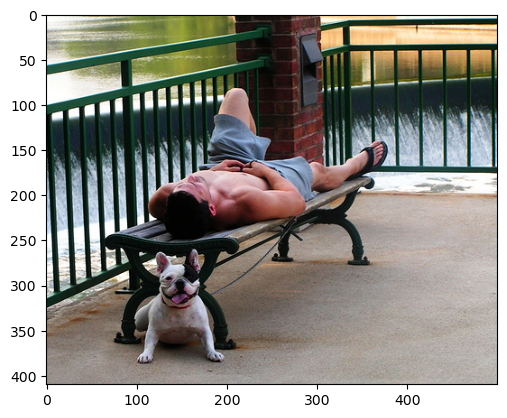

In [46]:
generate_caption('1003163366.jpg')